In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt

#%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical, plot_model  ##
from tensorflow.keras.preprocessing.image import load_img   ##
from tensorflow.keras.models import load_model, Model  ##
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input ##

In [2]:
datarute = r'C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFace-crop_Renamed'

In [3]:
img_name = []
age = []
gender = []


for filename in tqdm(os.listdir(datarute)):
  age.append(int(filename.split('_')[0]))
  gender.append(int(filename.split('_')[1]))
  img_name.append(os.path.join(datarute, filename))


100%|██████████| 23698/23698 [00:00<00:00, 90275.37it/s] 


In [6]:
df = pd.DataFrame()
df['Age'], df['Gender'], df['Img'] = age, gender, img_name
print(df.shape)
df = df.sample(frac=1).reset_index(drop=True)
df.head()



(23698, 3)


,Age,Gender,Img
0,1,1,C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFac...
1,25,1,C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFac...
2,45,0,C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFac...
3,16,0,C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFac...
4,37,0,C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFac...


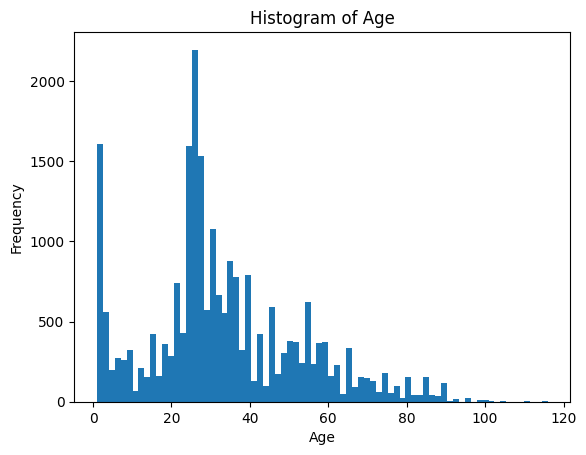

In [7]:
plt.hist(df['Age'], bins='auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.show()

In [8]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((192, 192), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 192, 192, 1)
    return features

In [9]:
X = extract_features(df['Img'])

  0%|          | 0/23698 [00:00<?, ?it/s]

100%|██████████| 23698/23698 [01:12<00:00, 324.67it/s]


In [10]:
print(X.shape)
X = X/255.0

(23698, 192, 192, 1)


In [14]:
y_gender = np.array(df['Gender'])
y_age = np.array(df['Age'])

input_shape = (192, 192, 1)

In [15]:
age_ranges = [(0, 2), (3, 5), (6, 12), (13, 17), (18, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74), (75, 100)]

def age_to_range(age):
    for i, age_range in enumerate(age_ranges):
        if age >= age_range[0] and age <= age_range[1]:
            return i
    return len(age_ranges) - 1

y_age_range = np.array([age_to_range(age) for age in y_age])

In [16]:
# Define the input shape for the model
inputs = Input((input_shape))

# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs) # 1st layer, 32 filters, 3x3 kernel size, and ReLU activation
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1) # First max pooling layer with 2x2 pool size

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1) # 2nd layer with 64 filters, 3x3 kernel size, and ReLU activation
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2) # Second max pooling layer with 2x2 pool size

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2) # 3er layer with 128 filters, 3x3 kernel size, and ReLU activation
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3) # Third max pooling layer with 2x2 pool size

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3) # 4th layer with 256 filters, 3x3 kernel size, and ReLU activation
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4) # Fourth max pooling layer with 2x2 pool size

# Flatten the convolutional features to use them in dense layers
flatten = Flatten()(maxp_4)

# Fully connected (Dense) layers
dense_1 = Dense(256, activation='relu')(flatten) # 1st dense layer with 256 neurons and ReLU activation
dense_2 = Dense(256, activation='relu')(flatten) # 2nd dense layer with 256 neurons and ReLU activation

# Apply dropout (30% of neurons will be turned off) to prevent overfitting
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers
# First output layer for gender prediction with 1 neuron and sigmoid activation
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
# Second output layer for age prediction with 1 neuron and softmax activation
num_age_ranges = len(age_ranges)
output_2 = Dense(num_age_ranges, activation='softmax', name='age_out')(dropout_2)


# Create the Keras model using the defined inputs and outputs
model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Watch the model layers 
intermediate_model = Model(inputs=inputs, outputs=[conv_1, maxp_1, conv_2, maxp_2, conv_3, maxp_3, conv_4, maxp_4])

# Compile the model with the appropriate loss function and optimizer
# - 'binary_crossentropy' for gender output since it's a binary classification (male/female)
# - 'mae' (Mean Absolute Error) for age output since it's a regression problem
# - Use 'adam' optimizer (an adaptive optimizer that works well in most cases)
model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
y_age_range_one_hot = to_categorical(y_age_range, num_classes=num_age_ranges)

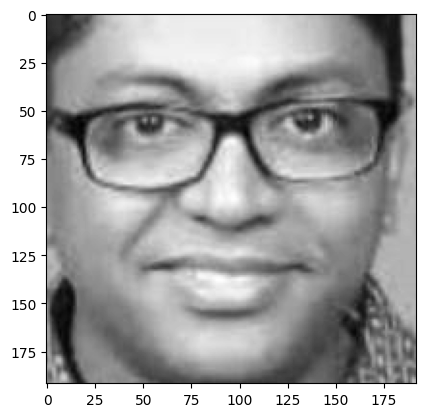

In [17]:
example_image = X[np.random.randint(0, X.shape[0])]
plt.imshow(example_image, cmap='gray')

1/1 [==============================] - 0s 122ms/step


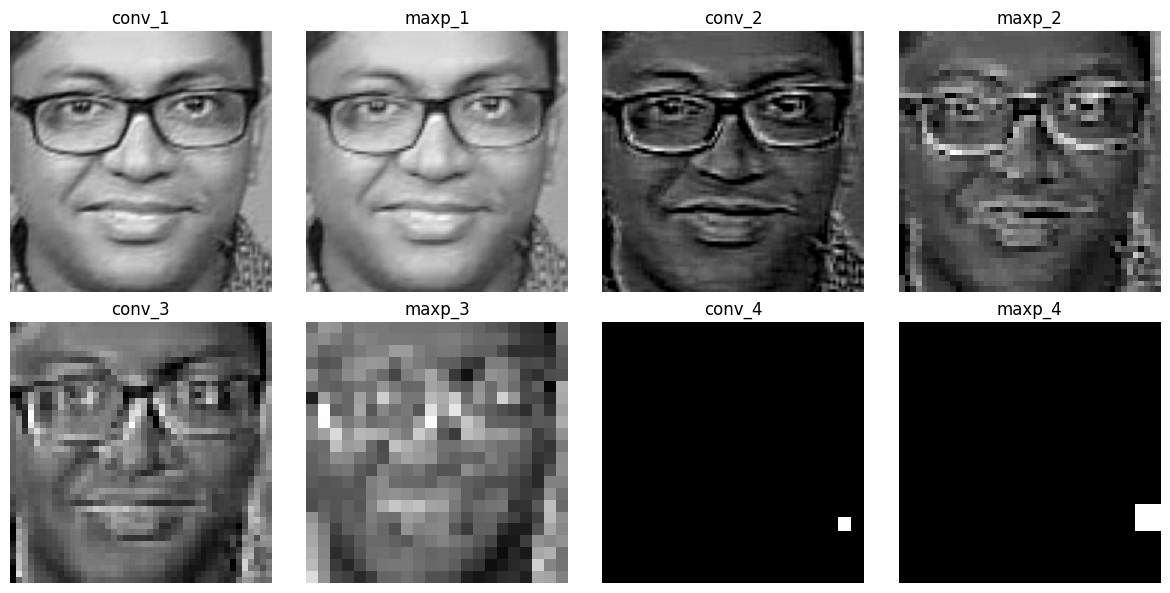

In [19]:
intermediate_outputs = intermediate_model.predict(np.expand_dims(example_image, axis=0))

intermediate_layer_names = ['conv_1', 'maxp_1', 'conv_2', 'maxp_2', 'conv_3', 'maxp_3', 'conv_4', 'maxp_4']
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(len(intermediate_layer_names)):
    output = intermediate_outputs[i][0]
    ax = axs[i // 4, i % 4]
    ax.imshow(output[:,:,0], cmap='gray')  # Mostrar solo el primer canal si es una imagen en escala de grises
    ax.set_title(intermediate_layer_names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [20]:
history = model.fit(x=X, y=[y_gender, y_age_range_one_hot], batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
593/593 [==============================] - 2209s 4s/step - loss: 2.2764 - gender_out_loss: 0.4810 - age_out_loss: 1.7954 - gender_out_accuracy: 0.7525 - age_out_accuracy: 0.3654 - val_loss: 1.8378 - val_gender_out_loss: 0.3461 - val_age_out_loss: 1.4917 - val_gender_out_accuracy: 0.8439 - val_age_out_accuracy: 0.4365
Epoch 2/20
 62/593 [==>...........................] - ETA: 62:50:27 - loss: 1.8033 - gender_out_loss: 0.3381 - age_out_loss: 1.4652 - gender_out_accuracy: 0.8498 - age_out_accuracy: 0.4325

In [15]:
model.save('Modelo_8Julio.h5')

In [16]:
image_index = 344
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = round(pred[0][0][0])
age_probs = pred[1][0]

print("Original Gender:", y_gender[image_index], "Original Age Range:", age_ranges[age_to_range(y_age[image_index])])
print("Predicted Gender:", pred_gender)
print("Probabilities for each age range:")

for i, prob in enumerate(age_probs):
    print("Age Range {}: {:0.2%}".format(age_ranges[i], prob))


1/1 [==============================] - 0s 310ms/step
Original Gender: 1 Original Age Range: (6, 12)
Predicted Gender: 1
Probabilities for each age range:
Age Range (0, 2): 0.00%
Age Range (3, 5): 0.13%
Age Range (6, 12): 99.81%
Age Range (13, 17): 0.01%
Age Range (18, 24): 0.05%
Age Range (25, 34): 0.00%
Age Range (35, 44): 0.00%
Age Range (45, 54): 0.00%
Age Range (55, 64): 0.00%
Age Range (65, 74): 0.00%
Age Range (75, 100): 0.00%
